
#MCHEZOPESA LTD MATCH OUTCOME PREDICTION 

**a) Data Analytic Questions**

We need to predictd result of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly.

**b) Success Metrics**

* Sucessful Exploratory Data Analysis.
* Sucessful feature engineering.
* Sucessful check of multicollinearity.
* Sucessful modeling.
* Sucessful Cross-validation of the model.
* Sucessful Computation of the RMSE
* Creation  of residual plots for the model
* Sucessful assessment their heteroscedasticity using Bartlett’s test

**c) context**

The aim of this project is to predict match outcomes of football matches, based on historical data that includes basic match data and FIFA ranking. In attempting to solve this problem, the analyst will perform;
* Feature transformation and dimensionality reduction techniques so as to increase the quality of the feature space. 
* Compare multiple classification algorithms and choose the one that performs best on a separate test dataset. 
* Finally apply probability calibration methods based on isotonic regression to increase the quality of class probability estimates.


**d) Experimental Design**

* Formulation of the research question.
* Loading the data.
* Exploratory Data Analysis.
* feature engineering.
* Multicollinearity check.
* Modeling.
* Cross-validation of the model.
* Computation of the RMSE.
* Creation  of residual plots for the model
* Heteroscedasticity assessment via Bartlett’s test
* Challenge the solution.
* Follow up.

#MATCH OUTCOME PREDICTION


#Loading required libraries

In [1]:
#Required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter("ignore")

# READING IN THE DATASET

#*Fifa_ranking data*

In [2]:
fifa_ranking=pd.read_csv("fifa_ranking.csv")
# check the shape 
fifa_ranking.shape


(57793, 16)

Top three

In [3]:
fifa_ranking.head(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08


Bottom three

In [4]:
#Check bottom 3 columns
fifa_ranking.tail(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
57790,206,Eritrea,ERI,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57792,206,Tonga,TGA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OFC,2018-06-07


Data info

In [5]:
fifa_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57793 entries, 0 to 57792
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rank                     57793 non-null  int64  
 1   country_full             57793 non-null  object 
 2   country_abrv             57793 non-null  object 
 3   total_points             57793 non-null  float64
 4   previous_points          57793 non-null  int64  
 5   rank_change              57793 non-null  int64  
 6   cur_year_avg             57793 non-null  float64
 7   cur_year_avg_weighted    57793 non-null  float64
 8   last_year_avg            57793 non-null  float64
 9   last_year_avg_weighted   57793 non-null  float64
 10  two_year_ago_avg         57793 non-null  float64
 11  two_year_ago_weighted    57793 non-null  float64
 12  three_year_ago_avg       57793 non-null  float64
 13  three_year_ago_weighted  57793 non-null  float64
 14  confederation         

*Convert the rank_date column to date format*

In [6]:
fifa_ranking['rank_date'] = pd.to_datetime(fifa_ranking['rank_date'])
#introduce new column year month
fifa_ranking['year_month'] = pd.to_datetime(fifa_ranking['rank_date']).dt.to_period('M')
fifa_ranking=fifa_ranking
fifa_ranking.sample(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,year_month
18781,22,Sweden,SWE,0.00,673,-2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2002-09-18,2002-09
46709,51,Wales,WAL,597.53,574,4,340.06,340.06,184.50,92.25,527.00,158.10,35.57,7.11,UEFA,2014-02-13,2014-02
54280,75,Uganda,UGA,464.08,476,-2,212.96,212.96,271.18,135.59,257.82,77.34,190.95,38.19,CAF,2017-02-09,2017-02


*Rename the rank_date column to date*

In [7]:
#fifa_ranking.rename(columns = { 'year_month': 'date'}, inplace = False)
#fifa_ranking.sample(1)

#*Results data*

In [8]:
results=pd.read_csv("results.csv")
 
results.shape


(40839, 9)

Top three

In [9]:
results.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False


Bottom three

In [10]:
results.tail(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
40836,2019-07-19,Senegal,Algeria,0,1,African Cup of Nations,Cairo,Egypt,True
40837,2019-07-19,Tajikistan,North Korea,0,1,Intercontinental Cup,Ahmedabad,India,True
40838,2019-07-20,Papua New Guinea,Fiji,1,1,Pacific Games,Apia,Samoa,True


Data info

In [11]:
# checking data info
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40839 entries, 0 to 40838
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        40839 non-null  object
 1   home_team   40839 non-null  object
 2   away_team   40839 non-null  object
 3   home_score  40839 non-null  int64 
 4   away_score  40839 non-null  int64 
 5   tournament  40839 non-null  object
 6   city        40839 non-null  object
 7   country     40839 non-null  object
 8   neutral     40839 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.5+ MB


*Convert the date column to date format*

In [12]:
results['date'] = pd.to_datetime(results['date'])
#introduce new column year month
results['year_month'] = pd.to_datetime(results['date']).dt.to_period('M')
result=results
results.sample(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year_month
34016,2012-05-31,France,Serbia,2,0,Friendly,Reims,France,False,2012-05
32725,2011-01-14,Panama,Belize,2,0,UNCAF Cup,Panama City,Panama,False,2011-01
8048,1972-01-12,Iraq,Algeria,3,1,Friendly,Baghdad,Iraq,False,1972-01


*Extract confederation by Spliting the tournament column into two columns*

In [ ]:
#Split the first part of tournament into column  “confederation” add it to the existing Dataframe
#results['confederation_r'] = results.tournament.str.split(expand=False)
#results['confederation_r'] = results.tournament.str.split(expand=True)
#results.head(3)

#DATA MERGING

*Data in pespective of home team*

In [47]:
home_team_scores= pd.merge(results,fifa_ranking, left_on= ['home_team', 'year_month'], 
                     right_on= ['country_full', 'year_month'], how = 'inner')

# renaming the rank colum to home_rank
home_team_scores.rename(columns={'rank' : 'home_team_rank'}, inplace=True)

home_team = home_team_scores[['date','home_team', 'away_team', 'home_team_rank','tournament','home_score']]
home_team

home_team_scores.head(2) 


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year_month,home_team_rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1993-08-01,Colombia,Paraguay,0,0,FIFA World Cup qualification,Barranquilla,Colombia,False,1993-08,19,Colombia,COL,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08
1,1993-08-15,Colombia,Argentina,2,1,FIFA World Cup qualification,Barranquilla,Colombia,False,1993-08,19,Colombia,COL,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


*Data in pespective of away team*

In [48]:
away_team_scores= pd.merge(results, fifa_ranking, left_on= ['away_team', 'year_month'], 
                     right_on= ['country_full', 'year_month'], how = 'inner')

# renaming the rank colum to home_rank
away_team_scores.rename(columns={'rank' : 'away_team_rank'}, inplace=True)
# extract unique colums for away_team

away_team = away_team_scores[['date','home_team','away_team', 'away_team_rank','year_month','tournament','away_score']]
away_team
away_team.head(2) 

,date,home_team,away_team,away_team_rank,year_month,tournament,away_score
0,1993-08-01,Colombia,Paraguay,67,1993-08,FIFA World Cup qualification,0
1,1993-08-29,Argentina,Paraguay,67,1993-08,FIFA World Cup qualification,0


#*Join the two data sets*

In [15]:
fifa= pd.merge(home_team_scores,away_team, left_on= ['date','home_team','away_team', 'year_month'], 
                     right_on= ['date','home_team','away_team', 'year_month'], how = 'inner')
fifa.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year_month,home_team_rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,away_team_rank
0,1993-08-01,Colombia,Paraguay,0,0,FIFA World Cup qualification,Barranquilla,Colombia,False,1993-08,19,Colombia,COL,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08,67
1,1993-08-15,Colombia,Argentina,2,1,FIFA World Cup qualification,Barranquilla,Colombia,False,1993-08,19,Colombia,COL,0.0,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08,5


In [16]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16957 entries, 0 to 16956
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     16957 non-null  datetime64[ns]
 1   home_team                16957 non-null  object        
 2   away_team                16957 non-null  object        
 3   home_score               16957 non-null  int64         
 4   away_score               16957 non-null  int64         
 5   tournament               16957 non-null  object        
 6   city                     16957 non-null  object        
 7   country                  16957 non-null  object        
 8   neutral                  16957 non-null  bool          
 9   year_month               16957 non-null  period[M]     
 10  home_team_rank           16957 non-null  int64         
 11  country_full             16957 non-null  object        
 12  country_abrv             16957 n

In [455]:
#fifa = pd.merge(results, fifa_ranking, left_on=['year_month','home_team','confederation_r'], right_on=['year_month','country_full','confederation'],how="inner")
#fifa.head(3)

*Drop Uneccesary columns*

In [17]:
fifa = fifa.drop(columns=['country_abrv','tournament','city','country','year_month','country_full','total_points','confederation','rank_date'])

#Determine from home team’s perspective if the game is a Win, Lose or Draw (W, L, D)

In [18]:
# Creat condition on how to grade the teams

grading_codition = [fifa['home_score'] > fifa['away_score'],
                    fifa['home_score'] < fifa['away_score'],
                    fifa['home_score'] == fifa['away_score']]

# Determination of each condition

grade = ['W', 'L', 'D']

# creating a new columnn status column using the conditions and values above

fifa['Out_come'] = np.select(grading_codition, grade)

fifa.head(3)

,date,home_team,away_team,home_score,away_score,neutral,home_team_rank,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,away_team_rank,Out_come
0,1993-08-01,Colombia,Paraguay,0,0,False,19,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67,D
1,1993-08-15,Colombia,Argentina,2,1,False,19,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,W
2,1993-08-29,Colombia,Peru,4,0,False,19,36,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70,W


#Exploratory Data Analysis


In [19]:
# standardizing the column names uniform.

fifa.columns = fifa.columns.str.replace('/', '').str.strip().str.lower()  # Dealing with the inconsistencies

fifa.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'neutral',
       'home_team_rank', 'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'away_team_rank', 'out_come'],
      dtype='object')

*checking for duplicate*

In [20]:
fifa.duplicated().any()

True

*checking the shape of the new data*

In [21]:
fifa.shape

(16957, 19)

*checking the uniques*

In [22]:
fifa.nunique()

date                       4469
home_team                   193
away_team                   193
home_score                   21
away_score                   14
neutral                       2
home_team_rank              209
previous_points            1378
rank_change                  96
cur_year_avg               3538
cur_year_avg_weighted      3538
last_year_avg              3345
last_year_avg_weighted     3250
two_year_ago_avg           3309
two_year_ago_weighted      3113
three_year_ago_avg         3368
three_year_ago_weighted    2974
away_team_rank              209
out_come                      3
dtype: int64

#Univariate analysis

*Check the percentage of wins,loss and draw*

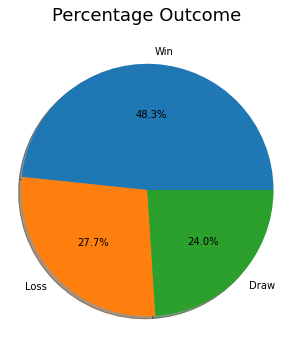

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,6))
plt.pie(fifa['out_come'].value_counts(),labels=['Win','Loss','Draw'], autopct='%1.1f%%',shadow=True, startangle=0)
plt.axis('equal')
plt.title('Percentage Outcome', size=18)
plt.show()

Home team

In [24]:
fifa['home_team'].value_counts()

Mexico                      253
Saudi Arabia                212
Japan                       207
Oman                        196
Qatar                       185
                           ... 
Kosovo                        8
Montserrat                    8
Gibraltar                     6
Anguilla                      6
Turks and Caicos Islands      3
Name: home_team, Length: 193, dtype: int64

away_team 

In [25]:
fifa['away_team'].value_counts()

Zambia                      191
Sweden                      163
Brazil                      162
Paraguay                    161
Finland                     161
                           ... 
Bahamas                      13
Turks and Caicos Islands      8
Kosovo                        6
Gibraltar                     6
Montserrat                    6
Name: away_team, Length: 193, dtype: int64

*checcking the numerical and categorical variables*

In [26]:
numerical = fifa._get_numeric_data().columns
categorical = set(fifa.columns) - set(numerical)
numerical 

Index(['home_score', 'away_score', 'neutral', 'home_team_rank',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'away_team_rank'],
      dtype='object')

*Checking outliers in numerical columns*

Index(['home_score', 'away_score', 'neutral', 'home_team_rank',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'away_team_rank'],
      dtype='object')


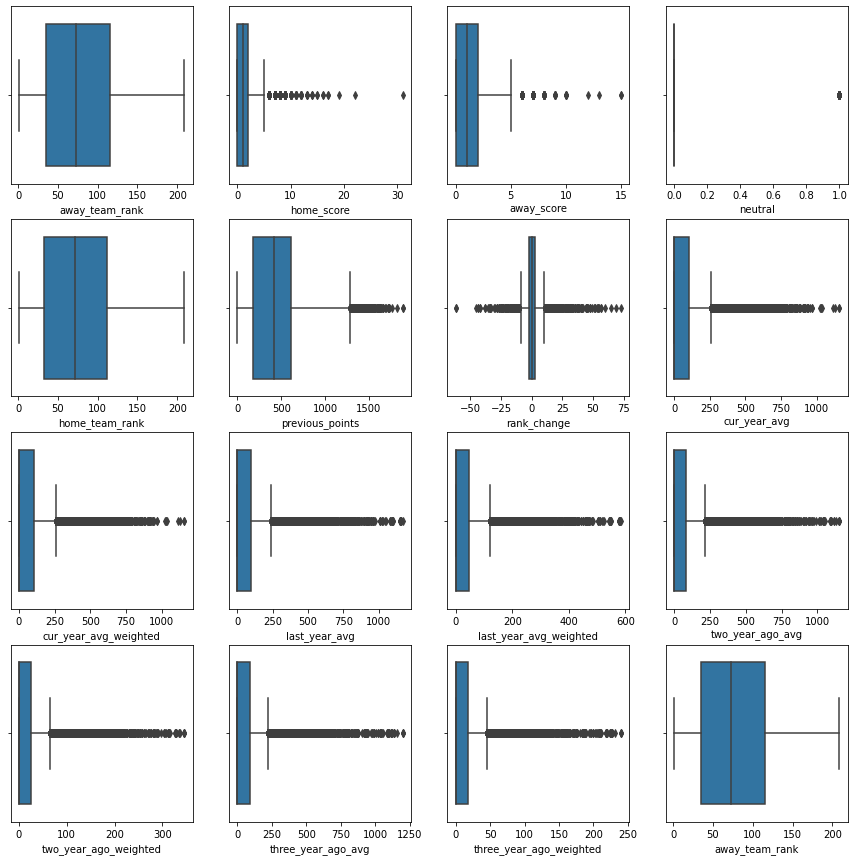

In [27]:
num_of_rows = 4
num_of_cols = 4
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(fifa[numerical[k-1]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1
plt.show()

Removing outliers in the numerical columns

In [28]:
lsUpper = []
lsLower = []
def removeOutliers(numerical):
    for i in range(len(numerical)):
        q1 = fifa[numerical[i]].quantile(0.25)
        q3 = fifa[numerical[i]].quantile(0.75)
        IQR = q3-q1
        minimum = q1 - 1.5 * IQR
        maximum = q3 + 1.5 * IQR
        fifa.loc[(fifa[numerical[i]] <= minimum), numerical[i]] = minimum
        fifa.loc[(fifa[numerical[i]] >= maximum), numerical[i]] = maximum  
removeOutliers(numerical)

Index(['home_score', 'away_score', 'neutral', 'home_team_rank',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'away_team_rank'],
      dtype='object')


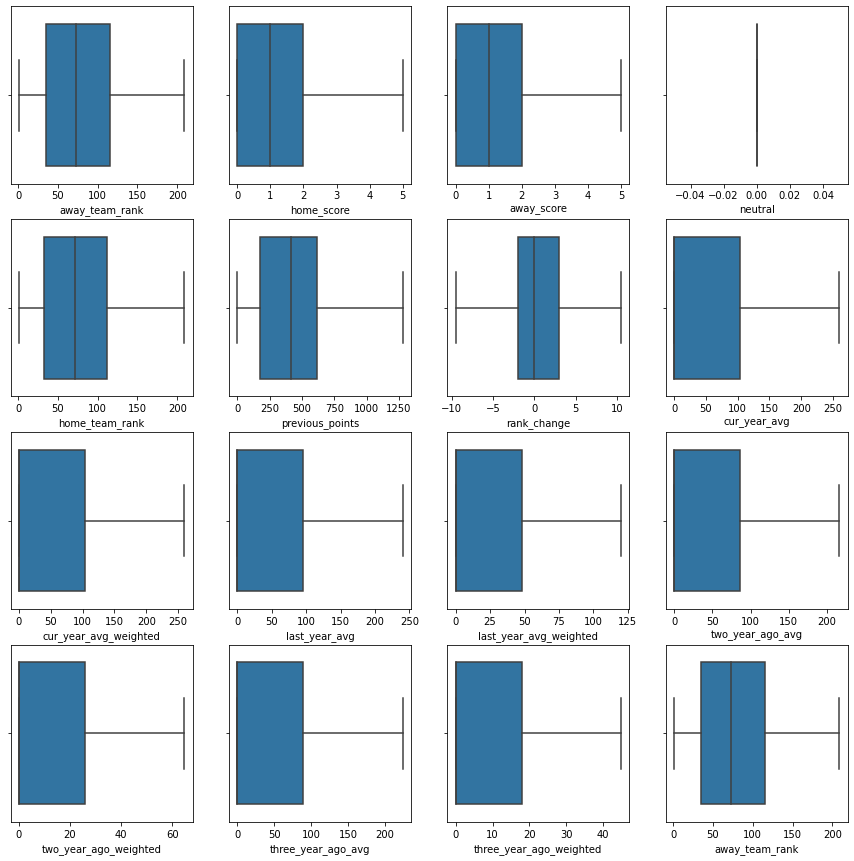

In [29]:
num_of_rows = 4
num_of_cols = 4
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(fifa[numerical[k-1]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1
plt.show()

Distribution of the numerical columns

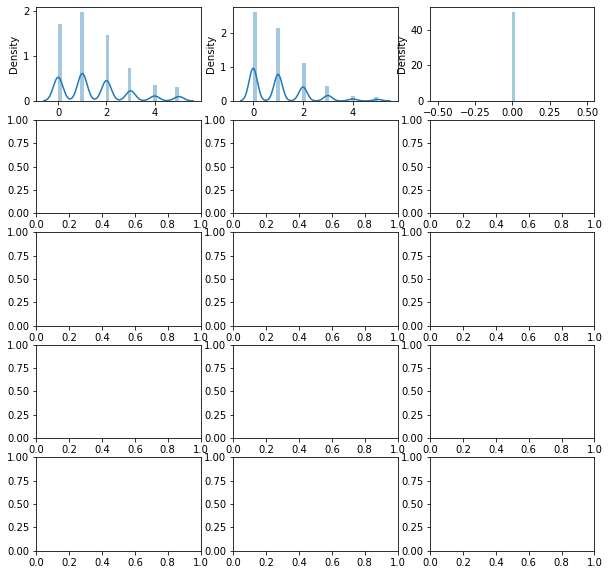

In [30]:
def plotHist():
    fig, ax =plt.subplots(5,3, figsize=(10,10))
    i=0;j=0;k=0
    while i<=4:
        while j<=2:
            sns.distplot(fifa[numerical[k]], ax=ax[i, j])
            j+=1;k+=1
        j=0;i+=1;
        plt.show()
plotHist()

#Bivariate Analysis

*Heat map showing correlation*

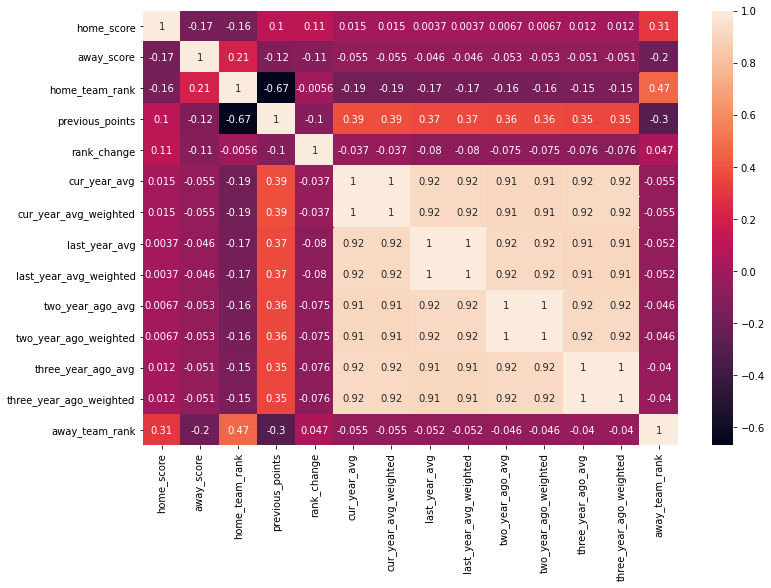

In [31]:
# Heat map showing correlation

plt.figure(figsize=(12, 8))

dfcorr = fifa.corr()
sns.heatmap(dfcorr, 
            xticklabels = dfcorr.columns.values,
            yticklabels = dfcorr.columns.values,
            annot = True);

#FEATURE ENGINEERING

#Principal Component Analysis (PCA)


*Encoding Categorical Features*

In [32]:
# Categorical boolean mask
categorical_feature_mask = fifa.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = fifa.columns[categorical_feature_mask].tolist()
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
fifa[categorical_cols] = fifa[categorical_cols].apply(lambda col: le.fit_transform(col))
fifa[categorical_cols].head(10)


,home_team,away_team,neutral,out_come
0,41,137,0,0
1,41,8,0,2
2,41,138,0,2
3,138,8,0,1
4,138,41,0,1
5,184,55,0,0
6,184,27,0,0
7,184,187,0,2
8,187,27,0,1
9,152,191,0,0


Distributing the dataset into two components X and Y

In [33]:
#Drop unneccessary columns
fifa=fifa.drop(['date'],axis=1)
#Set the values for x and y

x = fifa.drop('out_come',1)
y = fifa['out_come']



Splitting the dataset into the Training set and Test set

In [34]:
# Splitting the X and Y into Training set and Testing set

from sklearn.model_selection import train_test_split
  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Feature Scaling by fitting the data to a Standard scale.

In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Applying PCA function

In [36]:
# Applying PCA function on training and testing set of X component
from sklearn.decomposition import PCA
  
pca_rain = PCA(n_components =10)
  
x_train = pca_rain.fit_transform(x_train)
x_test = pca_rain.transform(x_test)

Explained_variance

In [37]:
explained_variance = pca_rain.explained_variance_ratio_
explained_variance 

array([0.48271943, 0.11444433, 0.09272254, 0.06370998, 0.06228638,
       0.05900557, 0.051727  , 0.02795026, 0.01437901, 0.01076765])

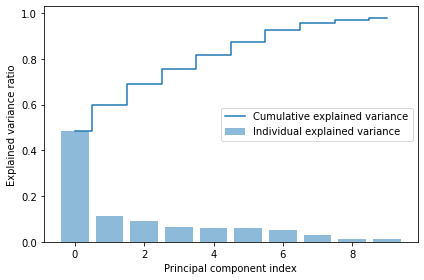

In [38]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = explained_variance
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The output shows that PC1, PC2 and PC3 prespectively account for approximately 48.27%,11.44% and 9.27% of the variance in the data set.

Eigendecomposition

a)Eigenvectors

In [39]:
cov_mat = np.cov(x_train.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)

Eigenvectors 
[[ 1.00000000e+00  2.63663015e-16  9.17926838e-17 -3.44790963e-17
   2.77467927e-18  8.24261275e-18  3.09913818e-17 -1.62279291e-16
   4.18827254e-17 -3.16782815e-18]
 [ 0.00000000e+00  1.00000000e+00  4.44576025e-17 -1.54874129e-16
   2.99573776e-17  8.53703189e-17  5.75963645e-17 -1.08623073e-15
   1.72292504e-16 -2.30194789e-16]
 [ 0.00000000e+00  8.73913094e-16  1.00000000e+00  2.91682580e-16
   2.66332948e-16 -1.45942597e-16  2.16899320e-16 -1.11708899e-15
   1.07747496e-15  3.62975029e-16]
 [ 0.00000000e+00  7.87889095e-16 -3.59660330e-16  2.60350666e-16
   4.87668949e-17  2.96007445e-16 -2.23010428e-16  1.00000000e+00
  -3.54482161e-14  5.26246730e-15]
 [ 0.00000000e+00 -8.92665123e-17 -1.47865636e-15  3.24042267e-17
   2.28678478e-16  5.58359677e-16 -1.30866169e-15  3.14857872e-14
   1.00000000e+00 -7.79486377e-15]
 [ 0.00000000e+00 -2.20019812e-16  2.37914854e-16  1.27600215e-16
  -4.26948678e-17 -2.04550450e-16  4.65100314e-16  4.46151342e-15
  -6.39202194e-15 -

b) Eigenvalues

In [40]:
print('\nEigenvalues \n%s' %eig_vals)


Eigenvalues 
[7.72408029 1.83124428 1.48367003 0.23008109 0.17229515 0.44723716
 0.82769297 1.01943481 0.99665557 0.94415879]


#Feature Importance
The importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude — higher importance)

In [486]:
#print(abs( pca_rain.components_ ))

[7.32769865e-05 3.53254272e-06 4.91820780e-01 5.07438037e-01
 0.00000000e+00 1.50299737e-04 8.31858860e-05 7.76478953e-06
 2.11249208e-05 4.30659419e-05 1.55009825e-05 1.83042228e-05
 1.30681761e-05 0.00000000e+00 4.02946404e-06 6.68427431e-06
 3.01345325e-04]


<BarContainer object of 17 artists>

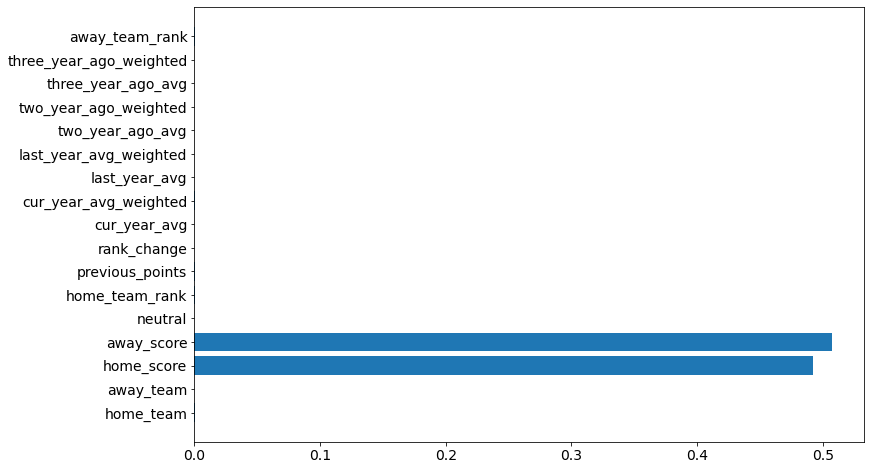

In [41]:
#Let’s find the most important features:
# Let's load the packages
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
#import shap
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})
#Load the data set and split for training and testing.
fifa2= fifa
X2 = fifa2.drop('out_come',1)
y2 = fifa2['out_come']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=12)

#Fit the Random Forest Regressor with 100 Decision Trees:

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X2_train, y2_train)

print(rf.feature_importances_)

#Let’s plot the importances (chart will be easier to interpret than values).

plt.barh(list(X2.columns), rf.feature_importances_)

#APPROACH 2: LOGISTIC APPROACH

#Fitting Logistic Regression

In [42]:
# Fitting Logistic Regression To the training set
from sklearn.linear_model import LogisticRegression  
  
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

*Predicting the test set result*

In [43]:
# Predicting the test set result using predict function under LogisticRegression 
y_pred = classifier.predict(x_test)
y_pred

array([2, 0, 0, ..., 2, 2, 2])

*Making the confusion matrix*

In [44]:
# making confusion matrix between test set of Y and predicted value.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
  
cm = confusion_matrix(y_test,y_pred)
print(cm)

print('\n','Accuracy\n' ,(accuracy_score(y_test,y_pred)*100),'%')
# Accuracy 100%

[[ 820    0    0]
 [   0  909    0]
 [   0    0 1663]]

 Accuracy
 100.0 %


#APPROACH 1: POLYNOMIAL APPROACH

#Model 1: Predict how many goals the home team scores.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#home_team = home_team_scores[['date','home_team', 'away_team', 'home_team_rank','tournament','home_score']]
#home_team

#load the data
data_ht =home_team

#--------------------- Encode the data--------------------------------------------------
# Categorical boolean mask
categorical_feature_mask = data_ht.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data_ht.columns[categorical_feature_mask].tolist()
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
data_ht[categorical_cols] = data_ht[categorical_cols].apply(lambda col: le.fit_transform(col))
data_ht[categorical_cols].head(10)
#----------------------------------------------------------------------------------------

# We will use 4 independent variables for this
hX = data_ht[['home_team', 'away_team', 'home_team_rank','tournament']].values
hy = data_ht['home_score'].values

# Train using 80% of the data.
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=0.2, random_state=0)

# find optimal coefficients and intercept
regressor = LinearRegression()  
regressor.fit(hX_train, hy_train)

# assess the accuraccy of the model
hy_pred = regressor.predict(hX_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(hy_test, hy_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(hy_test, hy_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(hy_test, hy_pred)))

Mean Absolute Error: 1.2078375863595352
Mean Squared Error: 3.2094909776436156
Root Mean Squared Error: 1.7915052267977383


Running the code above should yield an RMSE of ~3.2094. Let's now cross validate our model by using k-fold cross validation. 

#k-fold cross validation

In [54]:
from sklearn.model_selection import KFold

# We will use the same 4 independent variables for this

hX = data_ht[['home_team', 'away_team', 'home_team_rank','tournament']].values
hy = data_ht['home_score'].values

folds = KFold(n_splits=5)

# note that if you have a KFold object, you can figure out how many folds you set up 
# for it using get_n_splits
print('we are using ' +str(folds.get_n_splits(hX)) + ' folds')

# We now create and assess 5 models based on the folds we created.
RMSES = [] # We will use this array to keep track of the RSME of each model
count = 1 # This will just help 
for train_index, test_index in folds.split(hX):
  print('\nTraining model ' + str(count))
  
  # set up the train and test based on the split determined by KFold
  # With 5 folds, we will end up with 80% of our data in the training set, and 20% in the test set, just as above
  hX_train, hX_test = hX[train_index], hX[test_index]
  hy_train, hy_test = hy[train_index],hy[test_index]
  
  # fit a model accordingly
  regressor = LinearRegression()  
  regressor.fit(hX_train, hy_train)
  
  # assess the accuraccy of the model
  hy_pred = regressor.predict(hX_test)
  
  rmse_value =  np.sqrt(metrics.mean_squared_error(hy_test, hy_pred))
  RMSES.append(rmse_value)
  
  print('Model ' + str(count) + ' Root Mean Squared Error:',rmse_value)
  count = count + 1

we are using 5 folds

Training model 1
Model 1 Root Mean Squared Error: 1.72391552527832

Training model 2
Model 2 Root Mean Squared Error: 1.8452157945757344

Training model 3
Model 3 Root Mean Squared Error: 1.5820000000244767

Training model 4
Model 4 Root Mean Squared Error: 1.559177530199576

Training model 5
Model 5 Root Mean Squared Error: 1.5100821479279865


The RMSE value for our first model is equal to the RMSE we found initially.In this case, we will pick model 5 since it has the least RMSE.

In [55]:
np.mean(RMSES)

1.6440781996012188

#Let's now highlight some variants of k-folds.

 A popular variant is called the leave one out cross validation, where the test data is just a single observation from your set. For a dataset of size n, this is the same as using kfold to create n folds.

In [56]:
from sklearn.model_selection import LeaveOneOut


#load the data
data_ht =home_team

# We will use the same 4 independent variables for this
hX = data_ht[['home_team', 'away_team', 'home_team_rank','tournament']].values
hy = data_ht['home_score'].values

folds = LeaveOneOut()

# note that if you have a KFold object, you can figure out how many folds you set up 
# for it using get_n_splits
print('we are using ' +str(folds.get_n_splits(hX)) + ' folds')

# We now create and assess 5 models based on the folds we created.
RMSES = [] # We will use this array to keep track of the RSME of each model
count = 0 # This will just help 
for train_index, test_index in folds.split(hX):
  
  # set up the train and test based on the split determined by KFold
  # With 5 folds, we will end up with 80% of our data in the training set, and 20% in the test set, just as above
  hX_train, hX_test = hX[train_index], hX[test_index]
  hy_train, hy_test = hy[train_index], hy[test_index]
  
  # fit a model accordingly
  regressor = LinearRegression()  
  regressor.fit(hX_train, hy_train)
  
  # assess the accuraccy of the model
  hy_pred = regressor.predict(hX_test)
  
  rmse_value =  np.sqrt(metrics.mean_squared_error(hy_test, hy_pred))
  RMSES.append(rmse_value)
  
  count = count + 1
print('trained ' + str(count) + ' models' )
print(np.mean(RMSES))

we are using 18609 folds
trained 18609 models


1.18933313022588

In this scenario it is also helpful to plot out the RMSE values across all models:

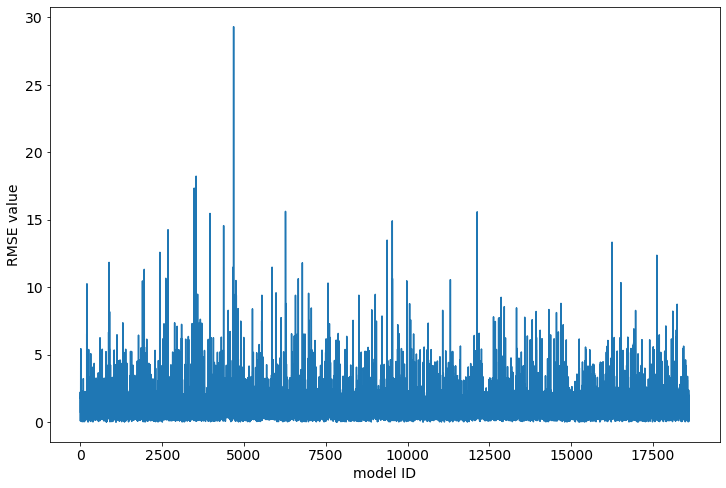

In [57]:
import matplotlib.pyplot as plt

plt.plot(RMSES)
plt.ylabel('RMSE value')
plt.xlabel('model ID')
plt.show()

#Assessing  heteroscedasticity via Bartlett’s test

#Polynomial Regression

In [88]:
#Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

# Import LinearRegression method from sklearn linear_model library
from sklearn.linear_model import LinearRegression

In [87]:
#load the data
#data_ht =home_team Encoded

hX = data_ht[['home_team']].values
hy = data_ht['home_score'].values

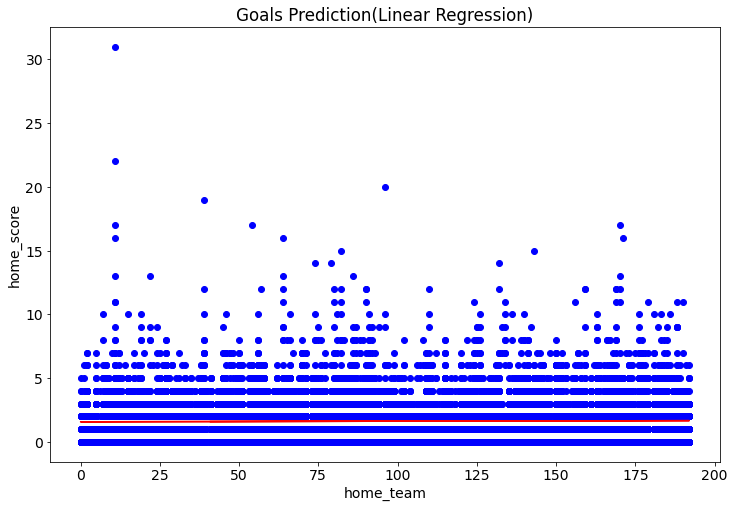

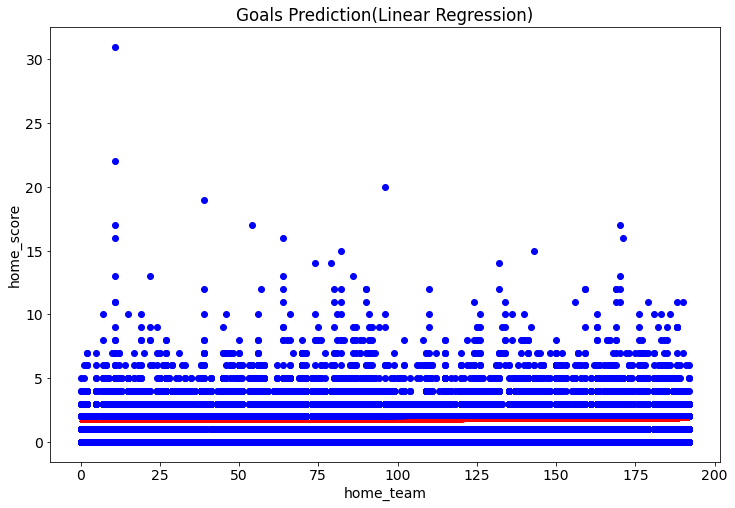

In [90]:
# Split the dataset into train and test sets
hX_train, hY_train, hX_test, hY_test = train_test_split(hX,hy, test_size = 0.2, random_state=0)


# Fit Linear Regression model to the dataset(this is optional. We are doing this for the sole purpose of comparing the linear regression model to the polynomial regression model)
reg_line = LinearRegression()
reg_line.fit(hX,hy)

# Visualize the Linear Regression results
plt.scatter(hX, hy, color='blue') # You can put any color you like. This just helps us highlight the data points
plt.plot(hX, reg_line.predict(hX), color='red')
plt.title('Goals Prediction(Linear Regression)')
plt.xlabel('home_team')
plt.ylabel('home_score')
plt.show()


# Fit polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 2) 
hX_poly = poly_reg.fit_transform(hX)


pol_reg = LinearRegression()
pol_reg.fit(hX_poly, hy)

#Visualize the Polynomial Regression results
plt.scatter(hX, hy, color='blue') # You can put any color you like. This just helps us highlight the data points
plt.plot(hX, pol_reg.predict(hX_poly), color='red')
plt.title('Goals Prediction(Linear Regression)')
plt.xlabel('home_team')
plt.ylabel('home_score')
plt.show()


#Optimization in Polynomial Regression

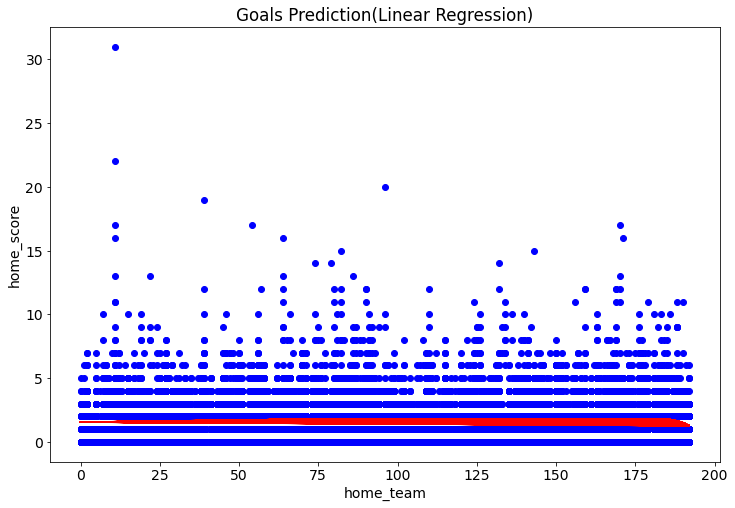

In [93]:
# To improve on the model, all we need to do is to increase degree of the polynomial
# Let's increase the degree to 3

# Fit polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree =10) 
hX_poly = poly_reg.fit_transform(hX)


pol_reg = LinearRegression()
pol_reg.fit(hX_poly, hy)

#Visualize the Polynomial Regression results
plt.scatter(hX, hy, color='blue') # You can put any color you like. This just helps us highlight the data points
plt.plot(hX, pol_reg.predict(hX_poly), color='red')
plt.title('Goals Prediction(Linear Regression)')
plt.xlabel('home_team')
plt.ylabel('home_score')
plt.show()

Obsevartion

We can conclude that this is a pretty good model because it passes just about the right amoung of points and also the distance from the curve to the points that it does not pass through is at a minimum. Hence, we can use this model to make our predictions.

#Making Predictions

The final step is use the model we created to make the our desired prediction.

To check how accurate polynomial regression is, we are going to predict the goals using both linear regression and polynomial regression

In [97]:
# Predict using linear regression
lin_pred = reg_line.predict([[125]])
print('Linear prediction: %d' %lin_pred)

# Predict using Polynomial Regression
poly_pred = pol_reg.predict(poly_reg.fit_transform([[125]]))
print('Polynomial prediction: %d' %poly_pred)

# We can also get the predictions as an array
poly_arr_pred = pol_reg.predict(poly_reg.fit_transform(hX))

Linear prediction: 1
Polynomial prediction: 1


#Conclusion

The predicted gaols for home team  using linear regression is one(1), Which is equivalent to the predicted gaols via polynomial regression is one(1).

#Challenge the solution.

Although the logistic and polinomial regression have sucessfully pridicted the outcome the solution could be improved through machine learning techniques.

#Follow up questions.

* **Do we need more predictor variables to carry out the task?**

  Probally yes be couse there are more factors influencing a macth out come.


* **Did the study adopt the correct regression technique?**
 
  OPen for further research.